Here is the list of "low input single cell approximation" (LISCA)
experiments.  Do you have an easy way to get FPKM tables for these?

In [1]:
import pandas
import numpy
import scipy.stats

In [2]:
from curation_common import *

In [3]:
%matplotlib inline
from matplotlib import pyplot

In [4]:
server = ENCODED('www.encodeproject.org')
server.load_netrc()

# Functions used later

## Data Loader

In [5]:
def load_fpkms(experiment_files):
    """Load FPKMs out of RSEM results into a pandas dataframe
    
    Columns will be library accession identifiers.
    """
    results = []
    libraries = []
    for i, row in enumerate(experiment_files):
        experiment = str(row['experiment'])
        library = str(row['library'])[-12:-1]
        url = str(row['file_href'])
        fpkms = pandas.read_csv(url, sep='\t', index_col=0, usecols=[0,6])
        libraries.append(library)
        results.append(fpkms)
    df = pandas.concat(results, axis=1)
    df.columns = libraries
    return df

## Correlation computations

In [6]:
def naive_scores(table, rep1_name, rep2_name):
    """Compute Naive correlations for two columns
    """
    rep1 = table[rep1_name]
    rep2 = table[rep2_name]
    scores = pandas.Series({
        'total rows': len(table),
        'passed filter': len(rep1),
        'Pearson': scipy.stats.pearsonr(rep1, rep2)[0],
        'Spearman': scipy.stats.spearmanr(rep1, rep2)[0]
    },
    index = ['total rows', 'passed filter', 'Pearson', 'Spearman']
    )
    return scores

In [7]:
def rafa_scores(table, rep1_name, rep2_name):
    """Compute Rafa's log transformed, filtered correlations and MAD scores
    """
    rep1 = table[rep1_name]
    rep2 = table[rep2_name]
    
    eitherzero = (rep1 == 0) | (rep2 == 0)
    replz1 = numpy.log2(rep1[eitherzero != True])
    replz2 = numpy.log2(rep2[eitherzero != True])
    
    M = replz1 - replz2
    A = (replz1 + replz2) / 2.0

    Acutoff = 0

    scores = pandas.Series({
        'total rows': len(table),
        'passed filter': len(replz1[A > Acutoff]),
        'Pearson': scipy.stats.pearsonr(replz1, replz2)[0],
        'Spearman': scipy.stats.spearmanr(replz1, replz2)[0],
        'MAD': numpy.round(numpy.median(numpy.abs(M)[A > Acutoff]) * 1.4826, 3),
        'SD': numpy.round(numpy.sqrt(numpy.mean(M[A > Acutoff] ** 2)), 3)
    },
    index = ['total rows', 'passed filter', 'Pearson', 'Spearman', 'MAD', 'SD']
    )
    return scores

In [8]:
def compute_all_vs_all_scores(fpkms):
    """Compute all the scores of note for a FPKM table.
    """
    shape = (len(fpkms.columns),len(fpkms.columns))
    s = {
        'Naive Pearson': numpy.zeros(shape),
        'Naive Spearman': numpy.zeros(shape),
        'Rafa Pearson': numpy.zeros(shape),
        'Rafa Spearman': numpy.zeros(shape),
        'Rafa MAD of logratios': numpy.zeros(shape),
        'Rafa SD of logratios': numpy.zeros(shape)
    }
    for i, rep1 in enumerate(fpkms.columns):
        for j, rep2 in enumerate(fpkms.columns):
            scores = naive_scores(fpkms, rep1, rep2)
            rafa = rafa_scores(fpkms, rep1, rep2)
            s['Naive Pearson'][i][j] = scores['Pearson']
            s['Naive Spearman'][i][j] = scores['Spearman']
            s['Rafa Pearson'][i][j] = rafa['Pearson']
            s['Rafa Spearman'][i][j] = rafa['Spearman']
            s['Rafa MAD of logratios'][i][j] = rafa['MAD']
            s['Rafa SD of logratios'][i][j] = rafa['SD']
    return s
        

## Plotting Functions

In [9]:
def heatmap(axes, table, score, title, vmin, vmax):
    """Try to intellgently format our heatmap.
    """
    ticks = range(len(table.columns))
    cax = axes.imshow(score, cmap=pyplot.cm.coolwarm, interpolation='none', vmin=vmin, vmax=vmax, origin='lower') 
    cax.axes.set_title(title)
    cax.axes.set_xticks(ticks)
    cax.axes.set_xticklabels(table.columns, rotation=90)
    cax.axes.set_yticks(ticks)
    cax.axes.set_yticklabels(table.columns)
    return cax
    

In [44]:
def plot_correlations(bulk_table, bulk_scores, small_table, small_scores, score):
    """Plot scores in the range [0, 1], like correlations.
    """
    fig, ax = pyplot.subplots(1, 2, figsize=(12,8))
    fig.suptitle(score, fontsize=16)
    pyplot.subplots_adjust(wspace=.4)
    cax = heatmap(ax[0], bulk_table, bulk_scores[score], 'Bulk', 0, 1)
    cax = heatmap(ax[1], small_table, small_scores[score], 'Small Input', 0, 1)
    cbar = pyplot.colorbar(cax, ticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9, 1], orientation='vertical')


In [42]:
def plot_mad(bulk_table, bulk_scores, small_table, small_scores, score):
    """Plot scores that aren't in the range [0, 1]
    """
    fig, ax = pyplot.subplots(1, 2, figsize=(12,8))
    fig.suptitle(score, fontsize=16)
    pyplot.subplots_adjust(wspace=.4)
    cax = heatmap(ax[0], bulk_table, bulk_scores[score], 'Bulk', None, None)
    cax = heatmap(ax[1], small_table, small_scores[score], 'Small Input', None, None)
    cbar = pyplot.colorbar(cax, orientation='vertical')


# Load Low Input Experiments

In [12]:
libs = [14626, 14629, 14495, 14630, 14627, 14631, 14628, 14632, 14499, 14633, 14501, 14634, 14485, 14486, 14487, 14488, 
        14653, 14654, 14655, 14656, 
        #14665, 14666, 
        14635, 14636
        ]

In [13]:
model = get_model(use_contexts=False)
for l in libs:
    alias = 'barbara-wold:%d' % (l,)
    print(alias)
    libdata = server.get_jsonld(alias)
    load_jsonld_into_model(model, libdata)
    search_results = server.search_jsonld(searchTerm=alias)
    for g in search_results['@graph']:
        if 'experiment' in g['@type']:
            experiment = server.get_jsonld(g['@id'])
            load_jsonld_into_model(model, experiment)


barbara-wold:14626
barbara-wold:14629
barbara-wold:14495
barbara-wold:14630
barbara-wold:14627
barbara-wold:14631
barbara-wold:14628
barbara-wold:14632
barbara-wold:14499
barbara-wold:14633
barbara-wold:14501
barbara-wold:14634
barbara-wold:14485
barbara-wold:14486
barbara-wold:14487
barbara-wold:14488
barbara-wold:14653
barbara-wold:14654
barbara-wold:14655
barbara-wold:14656
barbara-wold:14635
barbara-wold:14636


Loaded experiments

In [14]:
%%sparql -m model -c
select ?exp
where {
  ?exp a experiment:experiment .
}

Found 11 rows.


exp
experiments:ENCSR527RFK/
experiments:ENCSR026ZRP/
experiments:ENCSR861FGB/
experiments:ENCSR510ADJ/
experiments:ENCSR950BNG/
experiments:ENCSR265YFZ/
experiments:ENCSR225BBK/
experiments:ENCSR368QPC/
experiments:ENCSR000OXO/
experiments:ENCSR592MSV/


Find gene quantifications for the current annotation and group them by genome annotation M4. 

(Hopefully we weren't expecting human....)

In [15]:
%%sparql -m model -c -o experiment_files
select ?experiment ?library ?alias ?file_href ?output_type ?genome_annotation
where {
  ?experiment a experiment:experiment ;
              experiment:files ?file .
  ?file file:output_type ?output_type ;
        file:href ?file_href ;
        file:genome_annotation ?genome_annotation ;
        file:replicate ?replicate .
  ?replicate replicate:library ?library .
  ?library library:aliases ?alias .
  filter(regex(?output_type, "gene quantifications"))
  filter(regex(?genome_annotation, "M4"))
}
order by ?experiment ?alias
limit 40


Found 18 rows.


In [16]:
experiment_files

experiment,library,alias,file_href,output_type,genome_annotation
experiments:ENCSR000OXO/,libraries:ENCLB917PKP/,barbara-wold:14653,files:ENCFF005TWA/@@download/ENCFF005TWA.tsv,gene quantifications,M4
experiments:ENCSR000OXO/,libraries:ENCLB026BHP/,barbara-wold:14654,files:ENCFF550IBS/@@download/ENCFF550IBS.tsv,gene quantifications,M4
experiments:ENCSR026ZRP/,libraries:ENCLB719BQO/,barbara-wold:14495,files:ENCFF091FHP/@@download/ENCFF091FHP.tsv,gene quantifications,M4
experiments:ENCSR026ZRP/,libraries:ENCLB669AEL/,barbara-wold:14630,files:ENCFF447MON/@@download/ENCFF447MON.tsv,gene quantifications,M4
experiments:ENCSR265YFZ/,libraries:ENCLB304LFK/,barbara-wold:14501,files:ENCFF849RFV/@@download/ENCFF849RFV.tsv,gene quantifications,M4
experiments:ENCSR265YFZ/,libraries:ENCLB096HAH/,barbara-wold:14634,files:ENCFF021FHW/@@download/ENCFF021FHW.tsv,gene quantifications,M4
experiments:ENCSR510ADJ/,libraries:ENCLB652HKH/,barbara-wold:14628,files:ENCFF408DTF/@@download/ENCFF408DTF.tsv,gene quantifications,M4
experiments:ENCSR510ADJ/,libraries:ENCLB348BMH/,barbara-wold:14632,files:ENCFF393RNC/@@download/ENCFF393RNC.tsv,gene quantifications,M4
experiments:ENCSR527RFK/,libraries:ENCLB766UOB/,barbara-wold:14626,files:ENCFF923GRU/@@download/ENCFF923GRU.tsv,gene quantifications,M4
experiments:ENCSR527RFK/,libraries:ENCLB181TCJ/,barbara-wold:14629,files:ENCFF235UIN/@@download/ENCFF235UIN.tsv,gene quantifications,M4


In [17]:
low_fpkms = load_fpkms(experiment_files)

### Report scores for two related experiments

(As a check on correlation computations)

In [18]:
naive_scores(low_fpkms, 'ENCLB917PKP', 'ENCLB026BHP')

total rows       69690.000000
passed filter    69690.000000
Pearson              0.969447
Spearman             0.795169
dtype: float64

In [19]:
rafa_scores(low_fpkms, 'ENCLB917PKP', 'ENCLB026BHP')

total rows       69690.000000
passed filter     7888.000000
Pearson              0.626719
Spearman             0.716698
MAD                  1.344000
SD                   2.453000
dtype: float64

# Load ENCODE Bulk Evaluation Data

In [20]:
rna_model = get_model()
rna_evaluation = server.get_jsonld('https://www.encodeproject.org/datasets/ENCSR000AJW/')
load_jsonld_into_model(rna_model, rna_evaluation)

In [21]:
%%sparql -m rna_model -c -o rna_files
select ?experiment ?library ?file_href ?output_type ?genome_annotation
where {
  ?experiment a experiment:experiment ;
              experiment:files ?file .
  ?file file:output_type ?output_type ;
        file:href ?file_href ;
        file:genome_annotation ?genome_annotation ;
        file:replicate ?replicate .
  ?replicate replicate:library ?library .
  filter(regex(?output_type, "gene quantifications"))
}
order by ?experiment ?library
limit 40


Found 22 rows.


In [22]:
rna_files

experiment,library,file_href,output_type,genome_annotation
experiments:ENCSR000AEC/,libraries:ENCLB035ZZZ/,files:ENCFF088ZKJ/@@download/ENCFF088ZKJ.tsv,gene quantifications,V19
experiments:ENCSR000AEC/,libraries:ENCLB036ZZZ/,files:ENCFF610BLQ/@@download/ENCFF610BLQ.tsv,gene quantifications,V19
experiments:ENCSR000AED/,libraries:ENCLB037ZZZ/,files:ENCFF305LZB/@@download/ENCFF305LZB.tsv,gene quantifications,V19
experiments:ENCSR000AED/,libraries:ENCLB038ZZZ/,files:ENCFF239AZD/@@download/ENCFF239AZD.tsv,gene quantifications,V19
experiments:ENCSR000AEE/,libraries:ENCLB039ZZZ/,files:ENCFF009ZXH/@@download/ENCFF009ZXH.tsv,gene quantifications,V19
experiments:ENCSR000AEE/,libraries:ENCLB040ZZZ/,files:ENCFF219RWY/@@download/ENCFF219RWY.tsv,gene quantifications,V19
experiments:ENCSR000AEF/,libraries:ENCLB041ZZZ/,files:ENCFF392VPX/@@download/ENCFF392VPX.tsv,gene quantifications,V19
experiments:ENCSR000AEF/,libraries:ENCLB042ZZZ/,files:ENCFF023VHU/@@download/ENCFF023VHU.tsv,gene quantifications,V19
experiments:ENCSR000AEG/,libraries:ENCLB043ZZZ/,files:ENCFF486PVW/@@download/ENCFF486PVW.tsv,gene quantifications,V19
experiments:ENCSR000AEG/,libraries:ENCLB044ZZZ/,files:ENCFF428CJQ/@@download/ENCFF428CJQ.tsv,gene quantifications,V19


In [23]:
rna_fpkms = load_fpkms(rna_files)

In [24]:
naive_scores(rna_fpkms, 'ENCLB035ZZZ', 'ENCLB036ZZZ')

total rows       58540.000000
passed filter    58540.000000
Pearson              0.998247
Spearman             0.928167
dtype: float64

In [26]:
rafa_scores(rna_fpkms, 'ENCLB035ZZZ', 'ENCLB036ZZZ')

total rows       58540.000000
passed filter    12169.000000
Pearson              0.969915
Spearman             0.983032
MAD                  0.281000
SD                   0.365000
dtype: float64

# Compute the scores for all libraries vs all libraries

In [27]:
low_scores = compute_all_vs_all_scores(low_fpkms)

In [28]:
rna_scores = compute_all_vs_all_scores(rna_fpkms)

# Plot Correlations

Please note I sorted by experiment, and then by Library ID so the two replicates should have sorted next to each other.

In the small input Naive Pearsons you can see three blocks that correlate well with each other. I thought it'd be useful to go look them up and see what they were.

<table>
<thead>
<tr><td>Expermeint</td><td>Lib 1</td><td>Lib 2</td><td>Description</td></tr>
</thead>
<tbody>
<tr><td>ENCSR861FGB</td><td>ENCLB765HDK</td><td>ENCLB238LIR</td><td>RNA-Seq of hindbrain</td></tr>
<tr><td>ENCSR527RFK</td><td>ENCLB181TCJ</td><td>ENCLB766UOB</td><td>RNA-Seq of forebrain</td></tr>
<tr><td>ENCSR026ZRP</td><td>ENCLB669AEL</td><td>ENCLB719BQO</td><td>RNA-seq of midbrain</td></tr>
</tbody>
</table>

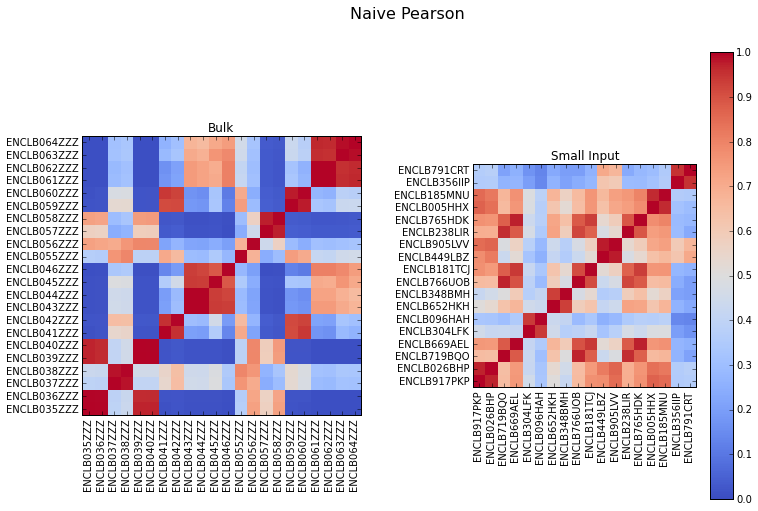

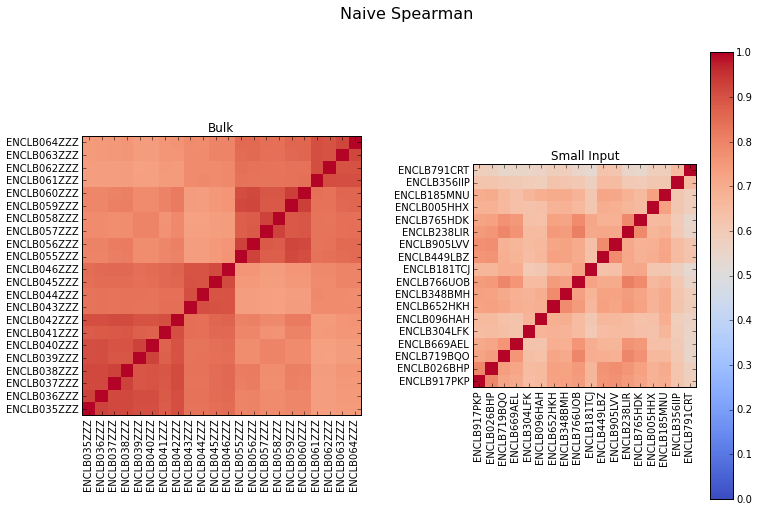

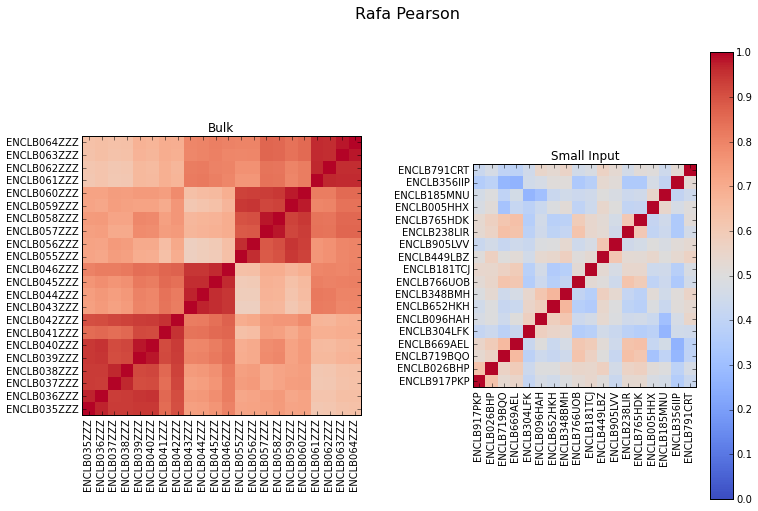

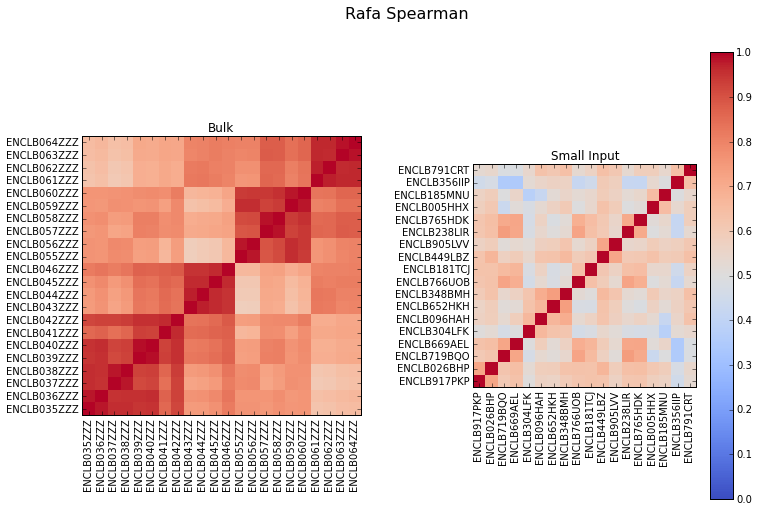

In [45]:
for names in ['Naive Pearson', 'Naive Spearman', 'Rafa Pearson', 'Rafa Spearman']:
    plot_correlations(rna_fpkms, rna_scores, low_fpkms, low_scores, names)

# Plot MAD and SD

**NOTE** Autoscale

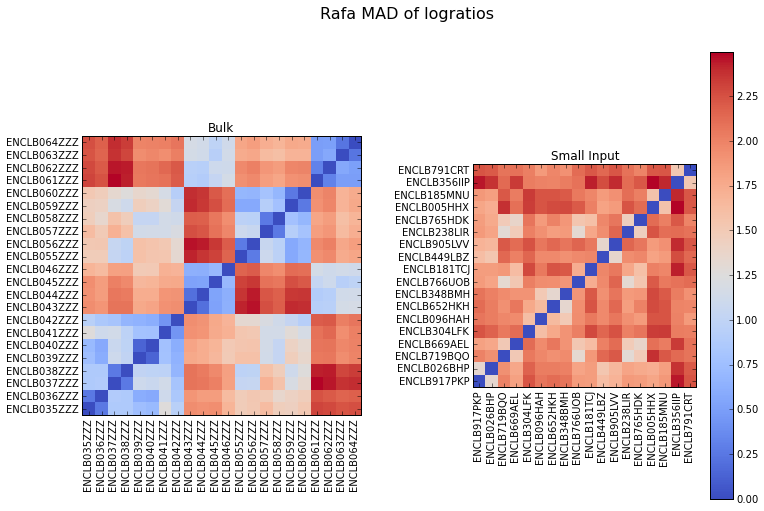

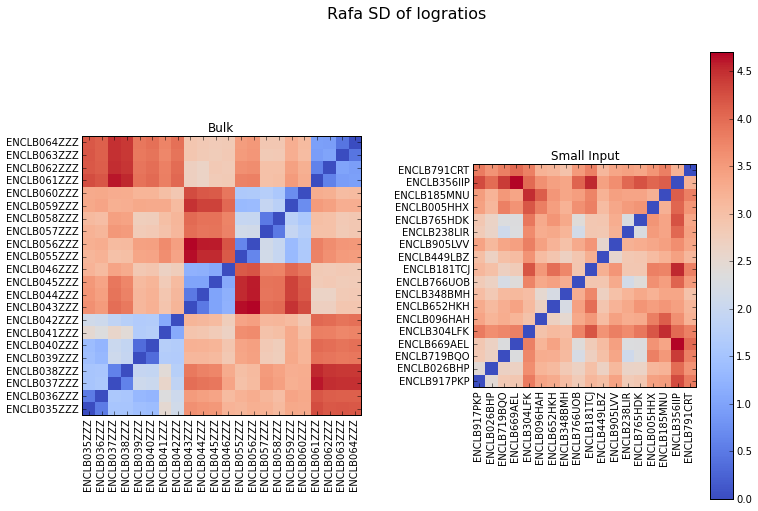

In [43]:
for names in ['Rafa MAD of logratios', 'Rafa SD of logratios']:
    plot_mad(rna_fpkms, rna_scores, low_fpkms, low_scores, names)

In [51]:
numpy.log2(.0000000000001)

-43.18506523353571